In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates

from forecasting_data_processing import df_to_X_y_multi_step

In [52]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *

In [53]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [54]:
# Load data from the CSV file
data = pd.read_csv('historical_data.csv')  

# Convert 'DATETIME' column to datetime format
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Set 'DATETIME' column as the index
data.set_index('DATETIME', inplace=True)

In [55]:
display(data.head())

,RR,SPO2,MAP,SBP,DBP,HR,PP,CO
DATETIME,,,,,,,,
2020-10-18 15:24:00,35.0,99.9,0.0,0.0,0.0,106.9,0.0,0.00
2020-10-18 15:25:00,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34
2020-10-18 15:26:00,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75
2020-10-18 15:27:00,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90
2020-10-18 15:28:00,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00


In [56]:
# Select both SBP and DBP columns
bp_df = pd.DataFrame({'SBP': data['SBP'], 'DBP': data['DBP']})

In [57]:
display(bp_df)

,SBP,DBP
DATETIME,,
2020-10-18 15:25:00,98.9,63.1
2020-10-18 15:26:00,97.9,63.0
2020-10-18 15:27:00,97.2,62.5
2020-10-18 15:28:00,96.0,62.0
2020-10-18 15:29:00,95.5,61.7
...,...,...
2020-10-24 21:32:00,92.0,51.2
2020-10-24 21:33:00,89.3,50.2
2020-10-24 21:34:00,91.2,50.6


In [58]:
# Split the data into training and testing sets with consideration for time dependency
split_index = int(len(bp_df) * 0.8)
train, test = bp_df.iloc[:split_index], bp_df.iloc[split_index:]
print(len(train))  
print(len(test))

7048
1763


In [59]:
# Define time steps and forecast horizon
window_size = 10  # Look back 10 minutes
forecast_horizon = 30  # Forecast the next 30 minutes

In [61]:
# Prepare input-output pairs
X_train, y_train = df_to_X_y_multi_step(train, window_size, forecast_horizon)
X_test, y_test = df_to_X_y_multi_step(test, window_size, forecast_horizon)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 2)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 2)).reshape(X_test.shape)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 2)).reshape(y_train.shape)
y_test_scaled = scaler.transform(y_test.reshape(-1, 2)).reshape(y_test.shape)



In [62]:
print(X_test[0])
print('-----')
print(len(y_test[0]))

[[96.9 55.9]
 [97.8 56.1]
 [97.3 55.8]
 [94.8 55. ]
 [95.6 55.3]
 [96.1 55.4]
 [95.8 55.6]
 [92.  55. ]
 [92.1 54.9]
 [91.6 54.7]]
-----
30


In [63]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7009, 10, 2), (7009, 30, 2), (1724, 10, 2), (1724, 30, 2))

In [65]:
# Model architecture for multi-step forecasting
model = keras.Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(forecast_horizon * 2))
model.add(Reshape((forecast_horizon, 2)))  # Reshape the output to match the target shape
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17152     
                                                                 
 dense_1 (Dense)             (None, 60)                3900      
                                                                 
 reshape_1 (Reshape)         (None, 30, 2)             0         
                                                                 
Total params: 21052 (82.23 KB)
Trainable params: 21052 (82.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
# Training the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/10
395/395 [==============================] - 6s 9ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 2/10
395/395 [==============================] - 3s 8ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 3/10
395/395 [==============================] - 3s 7ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 4/10
395/395 [==============================] - 3s 6ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 5/10
395/395 [==============================] - 2s 6ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 6/10
395/395 [==============================] - 3s 7ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 7/10
395/395 [==============================] - 3s 8ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 8/10
395/395 [==============================] - 3s 7ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 9/10
395/395 [==============================] - 3s 7ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 10/10
395/395 [==============================] - 3s 7ms/step - loss: 0.0018 - val_loss: 0.0035

In [68]:
# After training, you can use the model to make predictions for the next 30 minutes
predicted_values_scaled = model.predict(X_test_scaled)

# Inverse transform to get the predicted values in the original scale
predicted_values = scaler.inverse_transform(predicted_values_scaled.reshape(-1, 2)).reshape(predicted_values_scaled.shape)


54/54 [==============================] - 1s 5ms/step


In [ ]:
# Reshape y_test to match the shape of predicted_values
y_test_reshaped = y_test.reshape(-1, forecast_horizon * 2)

# Flatten predicted_values to match the shape of y_test_reshaped
predicted_values_flat = predicted_values.reshape(-1, forecast_horizon * 2)


In [76]:
# Evaluate the model
mse = mean_squared_error(y_test_reshaped, predicted_values_flat)
mae = mean_absolute_error(y_test_reshaped, predicted_values_flat)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 32.08063660375235
Mean Absolute Error: 3.9718666287088027
Root Mean Squared Error: 5.663977101273658


In [70]:
# Convert DATETIME to matplotlib datetime format
datetimes = bp_df.index

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Datetime': datetimes[:len(y_test_reshaped)],
    'Actual_SBP': y_test_reshaped[:, 0],
    'Predicted_SBP': predicted_values_flat[:, 0],
    'Actual_DBP': y_test_reshaped[:, 1],
    'Predicted_DBP': predicted_values_flat[:, 1]
})

# Display the DataFrame
print(results_df)



                Datetime  Actual_SBP  Predicted_SBP  Actual_DBP  Predicted_DBP
0    2020-10-18 15:25:00        93.5      92.126610        55.7      53.114964
1    2020-10-18 15:26:00        94.6      92.829796        55.6      53.544876
2    2020-10-18 15:27:00        93.5      93.417572        55.5      53.792400
3    2020-10-18 15:28:00        90.6      93.303009        54.3      53.769974
4    2020-10-18 15:29:00        91.0      91.969490        55.1      53.121418
...                  ...         ...            ...         ...            ...
1719 2020-10-19 20:49:00        93.9      93.320709        52.9      52.542831
1720 2020-10-19 20:50:00        96.1      92.785263        53.7      52.274567
1721 2020-10-19 20:51:00        95.4      93.497688        53.6      52.614487
1722 2020-10-19 20:52:00        93.2      93.582123        52.7      52.676052
1723 2020-10-19 20:53:00        95.1      92.645630        53.3      52.220135

[1724 rows x 5 columns]


In [71]:
results_df_subset = results_df[:30]

In [72]:
display(results_df_subset)

,Datetime,Actual_SBP,Predicted_SBP,Actual_DBP,Predicted_DBP
0,2020-10-18 15:25:00,93.5,92.126610,55.7,53.114964
1,2020-10-18 15:26:00,94.6,92.829796,55.6,53.544876
2,2020-10-18 15:27:00,93.5,93.417572,55.5,53.792400
3,2020-10-18 15:28:00,90.6,93.303009,54.3,53.769974
4,2020-10-18 15:29:00,91.0,91.969490,55.1,53.121418
5,2020-10-18 15:30:00,89.0,91.765266,54.5,53.147488
6,2020-10-18 15:31:00,89.3,90.862068,54.9,52.814629
7,2020-10-18 15:32:00,88.6,90.682022,54.6,52.850185
8,2020-10-18 15:33:00,88.0,90.297043,54.5,52.728325
9,2020-10-18 15:34:00,87.8,89.913322,54.8,52.608147


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14428\3789013063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_subset['Datetime'] = pd.to_datetime(results_df_subset['Datetime'])


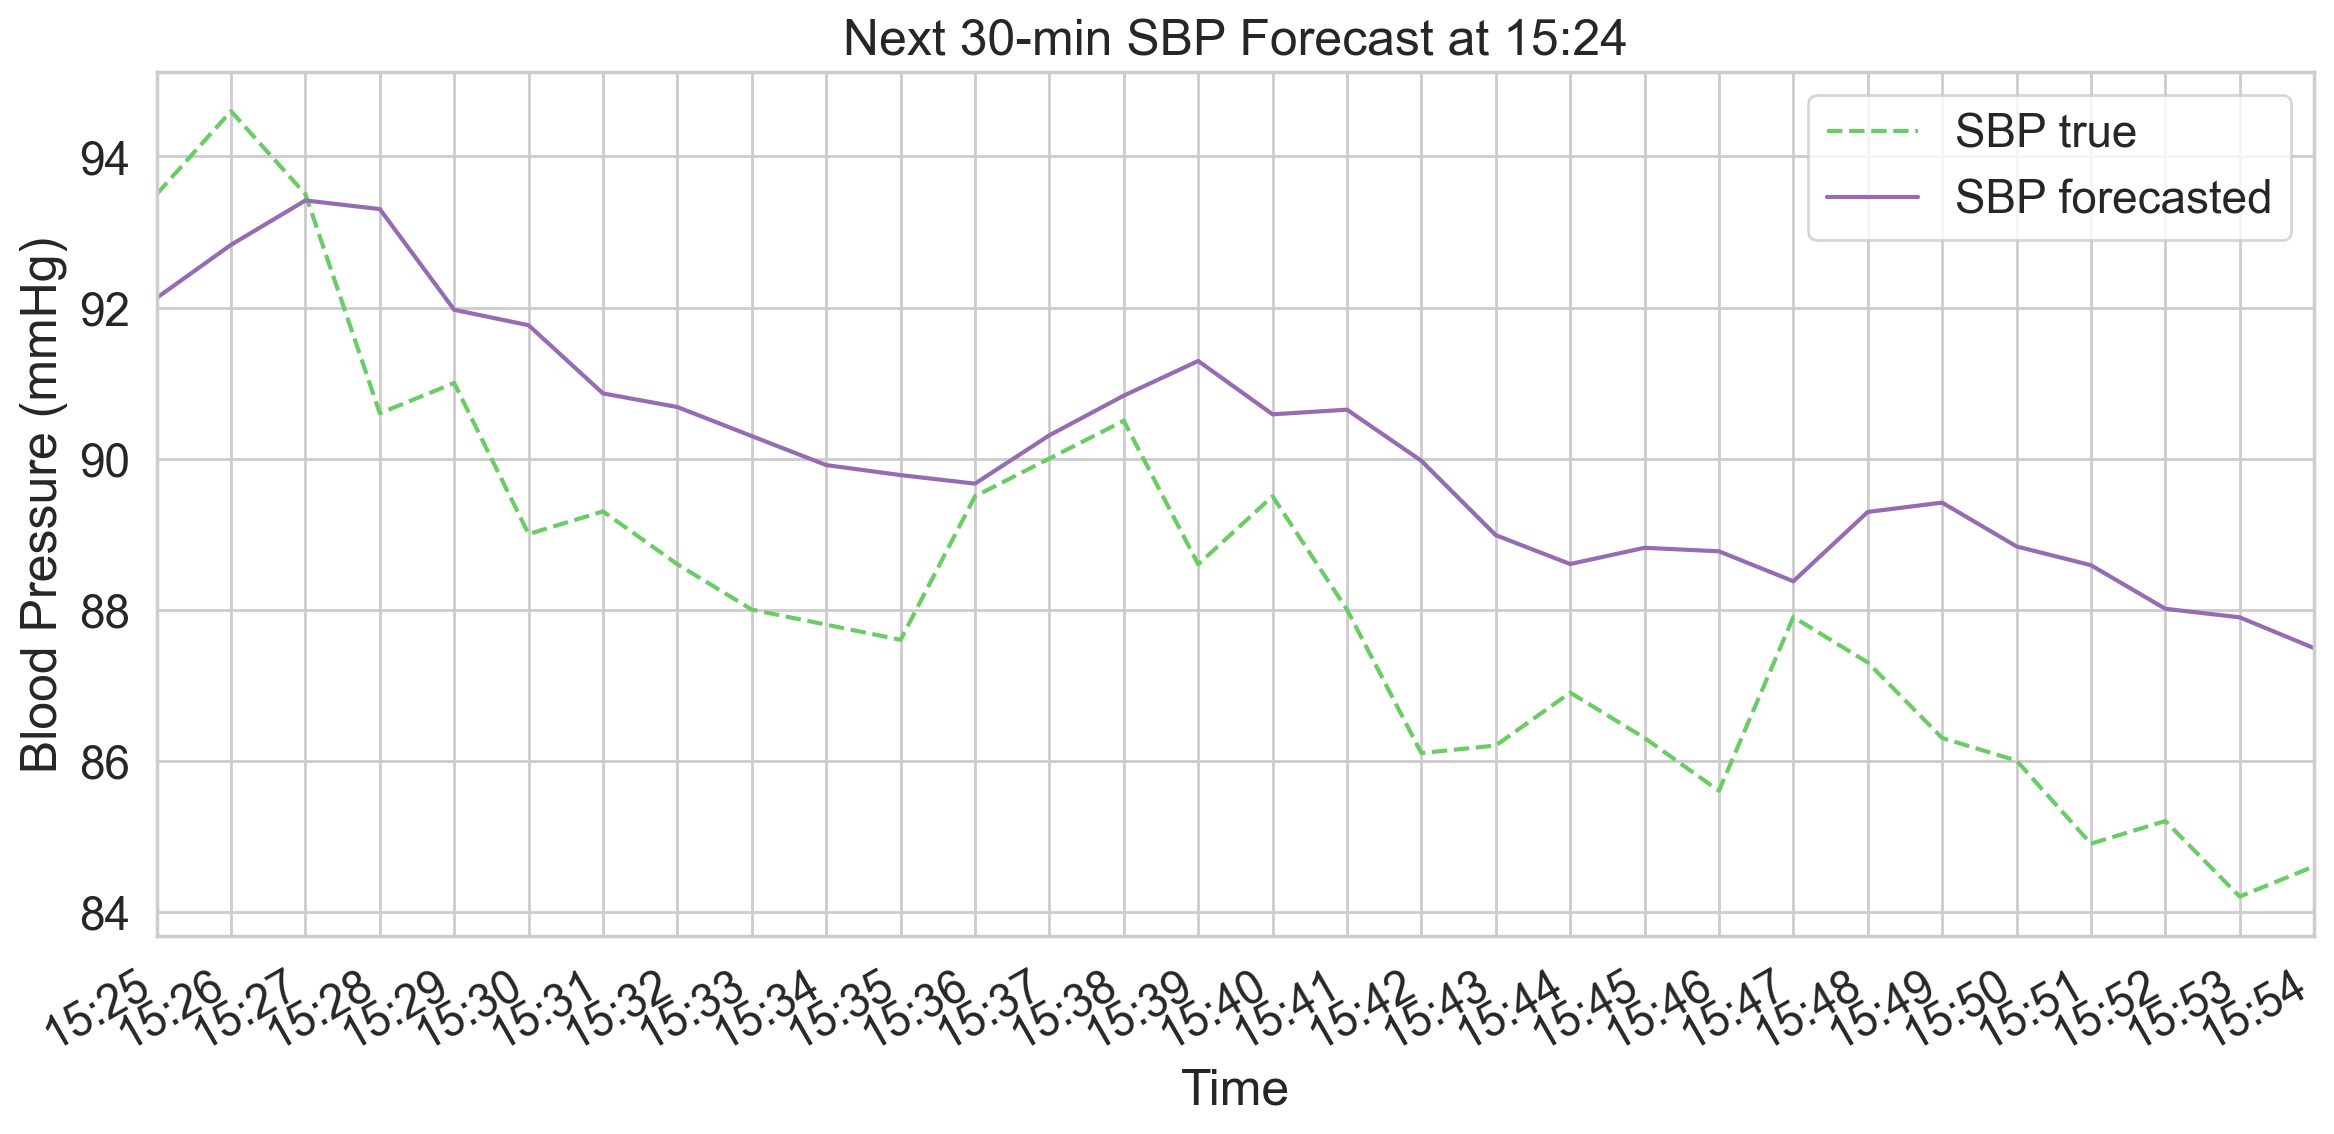

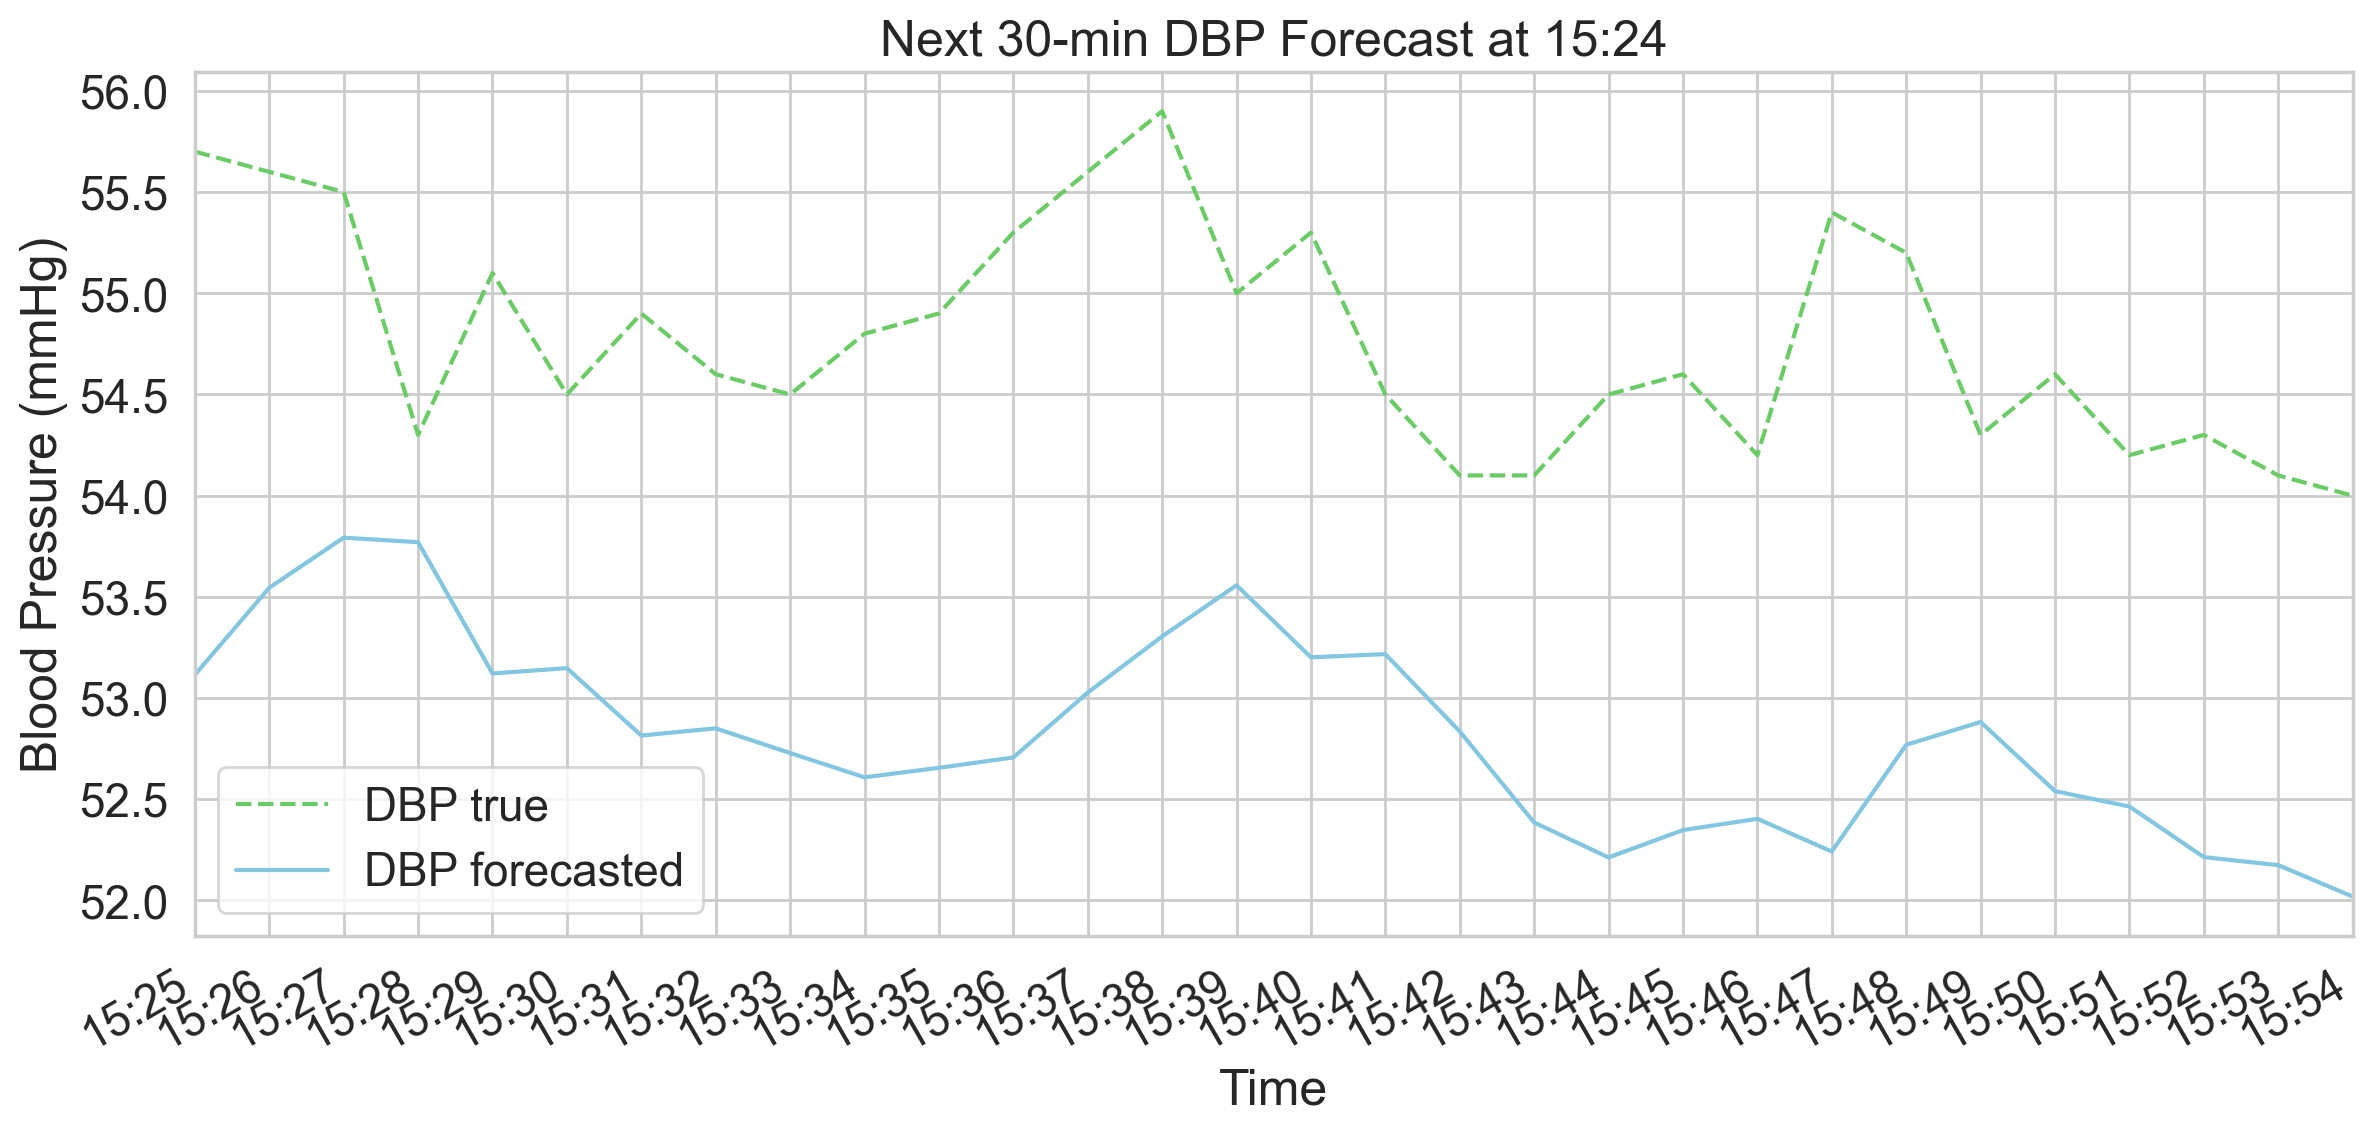

In [73]:
# Convert the 'Datetime' column to datetime format
results_df_subset['Datetime'] = pd.to_datetime(results_df_subset['Datetime'])
# Get the first datetime in the results_df_subset
first_datetime = results_df_subset['Datetime'].iloc[0]
# Calculate 1 minute before the first datetime
previous_minute = first_datetime - pd.Timedelta(minutes=1)
# Format the title
title = f'at {previous_minute.strftime("%H:%M")}'


# Plot SBP
plt.figure(figsize=(12, 6))
plt.plot(results_df_subset['Datetime'], results_df_subset['Actual_SBP'], 'g--', label="SBP true", markersize=2)
plt.plot(results_df_subset['Datetime'], results_df_subset['Predicted_SBP'], 'm-', label="SBP forecasted", markersize=2)
plt.ylabel('Blood Pressure (mmHg)')
plt.xlabel('Time')
plt.title(f'Next 30-min SBP Forecast {title}')
plt.legend()

# Set x-axis range from the minimum to the maximum datetime values
plt.xlim(results_df_subset['Datetime'].min(), results_df_subset['Datetime'].max())  # Add this line

plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=60))  # Set 1-minute ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format datetime with date, hour, minute, and second
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot DBP
plt.figure(figsize=(12, 6))
plt.plot(results_df_subset['Datetime'], results_df_subset['Actual_DBP'], 'g--', label="DBP true", markersize=2)
plt.plot(results_df_subset['Datetime'], results_df_subset['Predicted_DBP'], 'c-', label="DBP forecasted", markersize=2)
plt.ylabel('Blood Pressure (mmHg)')
plt.xlabel('Time')
plt.title(f'Next 30-min DBP Forecast {title}')
plt.legend()

# Set x-axis range from the minimum to the maximum datetime values
plt.xlim(results_df_subset['Datetime'].min(), results_df_subset['Datetime'].max())  # Add this line

plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=60))  # Set 1-minute ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format datetime with date, hour, minute, and second
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


In [74]:
# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(results_df_subset['Actual_SBP'], results_df_subset['Predicted_SBP'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(results_df_subset['Actual_SBP'], results_df_subset['Predicted_SBP'])

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 5.512093569665298
Root Mean Squared Error (RMSE): 2.3477848218406425
Mean Absolute Error (MAE): 2.089503021240235


In [77]:
from tensorflow.keras.models import save_model
model.save('multistep_sbp_dbp_forecasting_model.h5')

c:\Users\ASUS\anaconda3\envs\ost_project\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
